In [56]:
import functools
import math
import tqdm
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import sinc_dvr.func_basis as sdf
from integrators import get_crank_nicolson_solver

In [93]:
steps = (0.1, 0.1)
positive_extent = (20, 20)

In [94]:
inds = sdf.get_oinds(positive_extent, steps, verbose=True)
x, y = [ind * dw for ind, dw in zip(inds, steps)]
shape = [len(ind.ravel()) for ind in inds]
ip = sdf.get_inner_product_function(inds, steps)

Number of elements: 160801 distributed as: [401, 401]
Approximate size requirement for largest tensor (in GB): 0.004792243242263794


In [95]:
X, Y = x + jnp.zeros_like(y), y + jnp.zeros_like(x)

In [96]:
print("Setting up t_fft_circ")
t_fft_circ = sdf.get_t_fft_circ(inds, steps)
t_op = sdf.get_kinetic_matvec_operator(t_fft_circ)

Setting up t_fft_circ


In [97]:
v_pot = jax.jit(lambda x=x, y=y: -1 / jnp.sqrt(x**2 + y**2 + 1))

In [98]:
v_op = sdf.get_position_dependent_matvec_operator(inds, v_pot)

In [99]:
H = jax.jit(lambda t, c, t_op=t_op, v_op=v_op: t_op(c) + v_op(c))

In [100]:
rhs_imag = jax.jit(lambda t, c: -H(0, c))

In [101]:
solver = jax.jit(
    functools.partial(jax.scipy.sparse.linalg.cg, tol=1e-8),
    static_argnums=(0,),
)

In [102]:
@jax.jit
def normalize(c, ip=ip):
    return c / jnp.sqrt(ip(c.conj(), c))


def get_orthonormalizer(states):
    k = len(states)

    if k == 0:
        return normalize

    states = [*states, jnp.zeros_like(states[0])]

    @jax.jit
    def orthonormalize(c, states=jnp.array(states), k=k, normalize=normalize):
        states = states.at[k].set(c)
        b = jnp.zeros(k + 1)
        b = b.at[-1].set(1)
        return normalize(jnp.linalg.lstsq(states[: k + 1], b)[0])

    return orthonormalize

In [103]:
dtau = 0.5

In [104]:
integrate = get_crank_nicolson_solver(rhs_imag, dtau, solver=solver)

In [105]:
nrows = 3
ncols = 3
num_states = nrows * ncols
taus = []
imag_energies = []

states = []

In [106]:
for k in range(num_states):
    ort_norm = get_orthonormalizer(states)
    c = ort_norm(jnp.ones(math.prod(shape)).astype(complex))

    imag_energies_k = [ip(c.conj(), H(0, c))]
    tau = 0
    tau_k = [tau]

    for i in (pbar := tqdm.tqdm(range(10000))):
        pbar.set_description(f"Energies ({k}): {imag_energies_k[-1].real}")
        tau, c = integrate(tau, c)
        c = ort_norm(c)
        imag_energies_k.append(ip(c.conj(), H(0, c)))
        tau_k.append(tau)

        if abs(imag_energies_k[-1] - imag_energies_k[-2]) < 1e-5:
            break

    states.append(c)
    imag_energies.append(imag_energies_k)
    taus.append(tau_k)

Energies (8): -0.018140267580747604:   2%|███                                                                                                                                          | 221/10000 [03:33<2:37:15,  1.04it/s]


In [107]:
# Sort on energies
s_inds = jnp.argsort(jnp.array([k[-1] for k in imag_energies]))
states = [states[s] for s in s_inds]
imag_energies = [imag_energies[s] for s in s_inds]

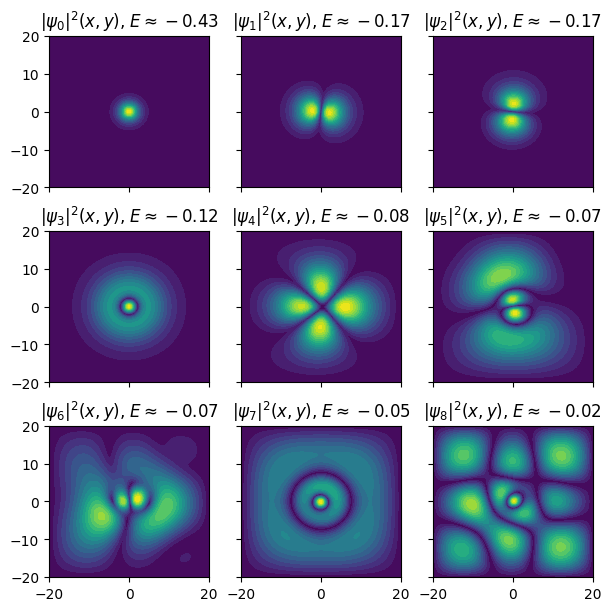

In [108]:
fig, axs = plt.subplots(
    figsize=(6, 6),
    nrows=nrows,
    ncols=ncols,
    layout="constrained",
    sharey=True,
    sharex=True,
    squeeze=False,
)


# Note that the ordering depends on the imaginary time-propagation
state = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].set_title(
            r"$|\psi_{"
            + f"{state}"
            + r"}|^2(x, y)$, $E \approx "
            + f"{imag_energies[state][-1].real:.2f}$"
        )
        axs[i, j].contourf(
            X, Y, jnp.abs(states[state].reshape(X.shape)).real, levels=20
        )
        state += 1